In [ ]:
# Project "Mare-tes" OFW Buddy System (MOBS)
# Machine Learning Model to Predict the missing buddy_score values
# Team: Mikas68
# Members: Cynthia A.Duque and Beulah Grace A. Duque
#
# REFERENCE: https://github.com/rachittoshniwal -- Student performance ML project
# For the sake of prototyping, the team has applied the code for the MOBS use case

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import joblib

In [41]:
df = pd.read_csv("ML_MOBS_new.csv")
df.head()

,usap_tayo_click,min_report_interval,frequency,doodle_pad_click,news_click,self_assessment,emoji score,buddy_s assessment
0,clicked,day,hourly,clicked,not_clicked,52,52,54
1,clicked,week,daily,clicked,clicked,49,70,68
2,clicked,day,weekly,clicked,not_clicked,70,75,73
3,not_clicked,hour,half-monthly,not_clicked,not_clicked,27,37,24
4,not_clicked,week,daily,clicked,not_clicked,56,58,55


In [ ]:
#  This is a proxy data for a thousand OFWs who used the MOBS mobile app for monthly 
#  ETL  processing. 
#
#  An ideal scenario is a complete set of scores coming from the radio buttons: self_score, 
#  emoji_choice, and buddy_score. 
#
#  Handling Exceptions for Alternate Scenarios: 
#  1•	A certain OFW-A who has been reporting his/her score has a peer OFW-B who did not submit
#       any assessment within a month in behalf of OFW-A. This situation will create an OFW-A
#       record with a missing buddy_score value
#      o	The issue will be addressed by the MOBS ML model by enabling the prediction of a 
#           missing buddy’s score 
# 2•	A certain OFW-A who did not submit any self-assessment for the month has a peer OFW-B 
#       who submitted an assessment for OFW-A. This situation will create an OFW-A record with 
#       missing self_score, emoji_score, and other system logs and will only contain the 
#       buddy_score only
#      o	The issue would require a different ML model that is appropriate for such prediction
#           requirement. It may also require additional features from the mobile app and/or policy
#           implementation to answer the question: How will the system handle the reliability and
#           impact of a reported status of an OFW-B (buddy) in behalf of a silent OFW-A?
#
#  As a limitation, this current version of MOBS-ML is designed to handle the first alternate 
#  scenario only.


In [42]:
df.shape

(1000, 8)

In [25]:
df.isna().sum()

usap_tayo_click        0
min_report_interval    0
frequency              0
doodle_pad_click       0
news_click             0
self_assessment        0
emoji score            0
buddy_s assessment     0
dtype: int64

In [43]:
scores = df.columns[df.columns.str.contains('score')].tolist()
scores

['emoji score']

In [ ]:
# Analyzing the data, we observe that the basic histograms is apparently gaussian with low skew and 
# kurtosis values -- also looks slightly left skewed. 

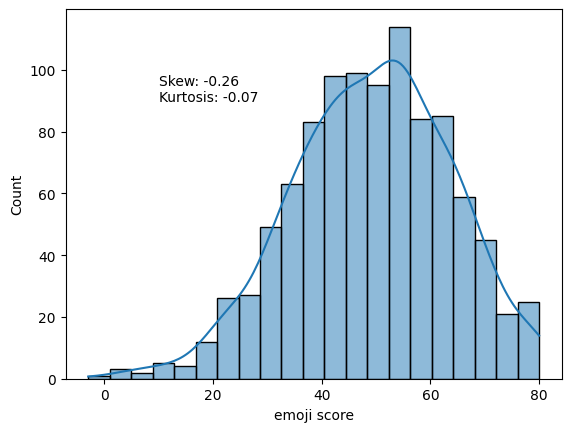

In [44]:
for score in scores:
    sns.histplot(df[score], element='bars', kde=True)
    plt.text(x=10, y=90, s=f"Skew: {round(df[score].skew(),2)}\nKurtosis: {round (df[score].kurt(),2)}")
    plt.show()

In [45]:
df.describe()

,self_assessment,emoji score,buddy_s assessment
count,1000.000000,1000.000000,1000.000000
mean,46.103000,49.169000,48.056000
std,15.115782,14.600192,15.189325
min,-20.000000,-3.000000,-10.000000
25%,37.000000,39.000000,37.750000
50%,46.000000,50.000000,49.000000
75%,57.000000,59.000000,59.000000
max,80.000000,80.000000,80.000000


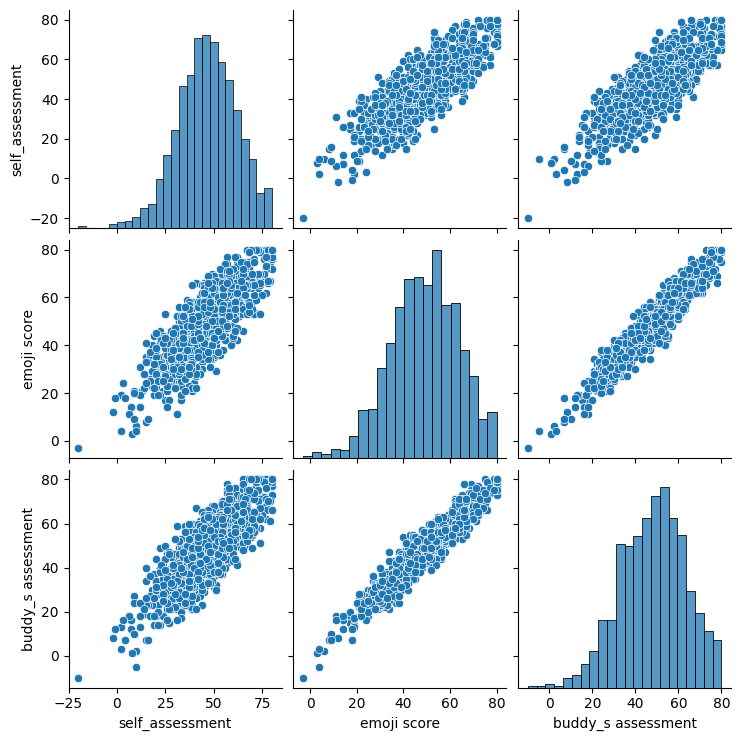

In [46]:
sns.pairplot(data=df)

In [ ]:
# We can observe here that all three scores are correlated with each other.  If the score is high in 
# one assessment, the scores for other assessments are apparently high as well 

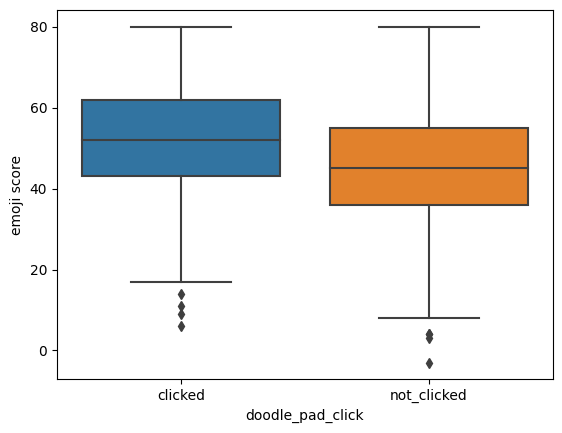

In [47]:
for score in scores:
    sns.boxplot(y=df[score], x=df['doodle_pad_click'])
    plt.show()

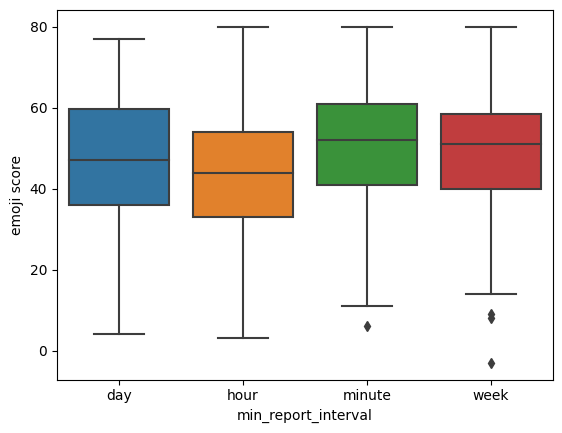

In [48]:
for score in scores:
    sns.boxplot(y=df[score], x=df['min_report_interval'], order=sorted(df['min_report_interval'].unique()))
    plt.show()

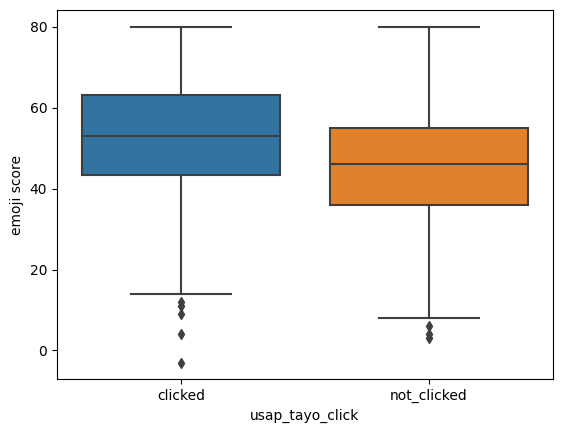

In [49]:
for score in scores:
    sns.boxplot(y=df[score], x=df['usap_tayo_click'])
    plt.show()

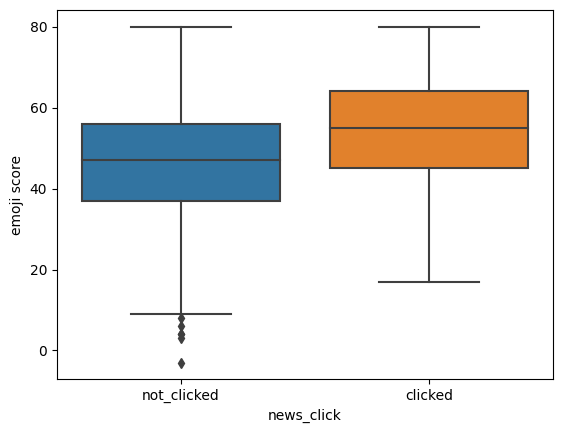

In [50]:
for score in scores:
    sns.boxplot(y=df[score], x=df['news_click'])
    plt.show()

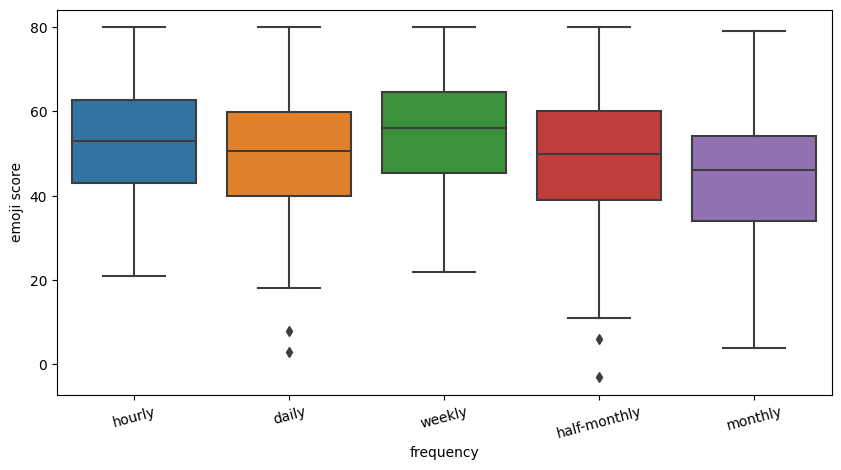

In [51]:
for score in scores:
    plt.figure(figsize=(10,5))
    sns.boxplot(y=df[score], x=df['frequency'])
    plt.xticks(rotation=15)
    plt.show()

In [52]:
# Transforming the Features: 
# Dependent or Target variable: buddy_score 
# Categorical columns: usap_tayo_click, news_click, doodle_pad_click, min_report_interval, frequency

In [ ]:
X, y = df.drop('buddy_score', axis=1), df['buddy_score']

In [ ]:
cat_cols = X.dtypes[X.dtypes == 'O'].index.tolist()
cat_cols

In [13]:
ct = ColumnTransformer([
#    ('num', StandardScaler(), ['self score', 'emoji score']),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'), cat_cols)
], remainder='passthrough')

In [ ]:
# We use OneHotEncoder to convert categorical columns into numeric variables

In [14]:
ct.fit_transform(X).shape

(1000, 17)

In [15]:
pipe = Pipeline ([
    ('trf', ct),
    ('model', LGBMRegressor(random_state=0))
])

In [36]:
# We first converted the entire dataset into something that can fit the ML model using a 
# ct.fit.transform(X),
# To make a pipeline we need:
# •	Column transformer
# •	Regressor of the stimulator which for this case we will use LGBMRegressor(random_state=0)


In [18]:
gs = GridSearchCV(pipe, param_grid=params, scoring='neg_root_mean_squared_error', n_jobs=-1)

In [ ]:
# We do a GridSearchCV to find the optimal set of parameters that will maximize the performance

In [19]:
gs.fit(X, y)

GridSearchCV(estimator=Pipeline(steps=[('trf',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         ['usap_tayo_click',
                                                                          'min_report_interval',
                                                                          'frequency',
                                                                          'doodle_pad_click',
                                                                          'news_click'])])),
                                       ('model',
                                        LGBMRegressor(random_state=0))]),
             n_jobs=-1,
             param_grid={'model__boosting_type': ['dart', 'gbdt', 'goss'],
                         'model__n_estimators': [100, 130, 150, 170, 190]},
             scoring='neg_root_mean_squared_error')

In [20]:
pd.DataFrame(gs.cv_results_).sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__boosting_type,param_model__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
10,0.046675,0.001715,0.007182,1.163211e-03,goss,100,"{'model__boosting_type': 'goss', 'model__n_est...",-4.450433,-3.977996,-3.766709,-3.631202,-4.107749,-3.986818,0.284448,1
11,0.058246,0.003710,0.007580,7.976653e-04,goss,130,"{'model__boosting_type': 'goss', 'model__n_est...",-4.478957,-3.996949,-3.783794,-3.647268,-4.091205,-3.999635,0.285969,2
13,0.068219,0.002863,0.007979,6.308266e-04,goss,170,"{'model__boosting_type': 'goss', 'model__n_est...",-4.483249,-4.043141,-3.760516,-3.642825,-4.120436,-4.010034,0.294727,3
12,0.065427,0.003764,0.007380,4.887143e-04,goss,150,"{'model__boosting_type': 'goss', 'model__n_est...",-4.457679,-4.049323,-3.787280,-3.660013,-4.104454,-4.011750,0.276754,4
14,0.069814,0.005240,0.005985,6.397442e-07,goss,190,"{'model__boosting_type': 'goss', 'model__n_est...",-4.511527,-4.029881,-3.790961,-3.676846,-4.136748,-4.029192,0.291588,5
5,0.072209,0.005030,0.007380,4.886559e-04,gbdt,100,"{'model__boosting_type': 'gbdt', 'model__n_est...",-4.433784,-3.939105,-3.850574,-3.882737,-4.294446,-4.080129,0.237719,6
6,0.089164,0.002149,0.008577,4.894347e-04,gbdt,130,"{'model__boosting_type': 'gbdt', 'model__n_est...",-4.507167,-3.984914,-3.907864,-3.904207,-4.325948,-4.126020,0.245743,7
7,0.100334,0.002570,0.009575,7.975819e-04,gbdt,150,"{'model__boosting_type': 'gbdt', 'model__n_est...",-4.526725,-3.996828,-3.939974,-3.908324,-4.358250,-4.146020,0.249475,8
8,0.111903,0.002221,0.009575,4.889867e-04,gbdt,170,"{'model__boosting_type': 'gbdt', 'model__n_est...",-4.532935,-4.015828,-3.969853,-3.923682,-4.383429,-4.165145,0.245624,9
9,0.131652,0.001668,0.011169,7.470044e-04,gbdt,190,"{'model__boosting_type': 'gbdt', 'model__n_est...",-4.543369,-4.031387,-3.991115,-3.945066,-4.420226,-4.186232,0.245971,10


In [21]:
gs.best_params_

{'model__boosting_type': 'goss', 'model__n_estimators': 100}

In [22]:
gs.best_score_

-3.986817816674879

In [76]:
gs.best_estimator_

Pipeline(steps=[('trf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['gender', 'race/ethnicity',
                                                   'parental level of '
                                                   'education',
                                                   'lunch',
                                                   'test preparation '
                                                   'course'])])),
                ('model', LGBMRegressor(random_state=0))])

In [ ]:
# Now we can dump this into a file called model.joblib 

In [23]:
joblib.dump(gs.best_estimator_, 'model.joblib')

['model.joblib']

In [ ]:
# Now if we want to input that file, we can do joblib.load with the name 
# and location of the file

In [25]:
mdl = joblib.load('model.joblib')

In [ ]:
# Passing on the parameters

In [26]:
q = pd.DataFrame([['clicked', 'week', 'daily', 'clicked', 'clicked', 20,21]],
                columns=X.columns)
q

,usap_tayo_click,min_report_interval,frequency,doodle_pad_click,news_click,self_score,emoji score
0,clicked,week,daily,clicked,clicked,20,21


In [27]:
mdl.predict(q)

array([24.41859481])

In [ ]:
# With the given values, buddy_score is predicted to be approx 24
#
# We can try finding better results with other regressor like linear regression, a random forest, or a 
# decision tree to come up with a better model.
#
# But for the purpose of prototyping and for us newbies, we just opted to follow the code of 
# Rachit Toshniwal and just considered LGBM for the MOBS-Machine Learning backend solution.
#
# REFERENCE: Toshniwal,R.https://github.com/rachittoshniwal